In [ ]:
;git -C COVID-19 pull

In [2]:
using 
CSV,
Dates,
DataFrames,
Markdown,
Plots,
Statistics,
StatsPlots

In [ ]:
death_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
# recovered_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
confirmed_path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [ ]:
death = CSV.read(death_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))
# recovered became deprecated
# recovered = CSV.read(recovered_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))
confirmed = CSV.read(confirmed_path) |> DataFrame! |> x -> rename!(x, Dict(Symbol("Province/State") => :state, Symbol("Country/Region") => :country))

In [ ]:
function country_data(country; state=false, start_date=Dates.Date(2020, 1, 22), end_date="max")
    aggregate(x) = [sum(col) for col in eachcol(x)]
    
    state_mask = typeof(state) == String ? death.state .== state : true
    d = death[(death.country .== country) .& state_mask, 5:end] |> aggregate
    dates = [Dates.Date(2020, 1, 22) + Dates.Day(day) for day in 1:length(d)] |> x -> reshape(x, :, 1)
#    state_mask = typeof(state) == String ? recovered.state .== state : true
#     r = recovered[(recovered.country .== country) .& state_mask, 5:end] |> aggregate
    state_mask = typeof(state) == String ? confirmed.state .== state : true
    c = confirmed[(confirmed.country .== country) .& state_mask, 5:end] |> aggregate
    
    df = convert(DataFrame, dates) |> x -> rename!(x, [:date])
    country_name = typeof(state) == String ? country * "-" * state : country
    df[!, :country] .= country_name
    df[!, :confirmed] = c
#    df[!, :recovered] = r
    df[!, :deaths] = d
#     df[!, :active] = c .- r .- d
    df[!, :death_rate] = d ./ c
    df[!, :new_cases] .= 0
    df[2:end, :new_cases] = df[2:end, :confirmed] .- df[1:end-1, :confirmed]
    df[!, :new_deaths] .= 0
    df[2:end, :new_deaths] = df[2:end, :deaths] .- df[1:end-1, :deaths]
    df[!, :acceleration_cases] .= 0
    df[2:end, :acceleration_cases] = df[2:end, :new_cases] .- df[1:end-1, :new_cases]
    df[!, :acceleration_deaths] .= 0
    df[2:end, :acceleration_deaths] = df[2:end, :new_deaths] .- df[1:end-1, :new_deaths]
    df[!, :days_since_100] .= 0
    counter = 0
    for row in eachrow(df)
        if row.confirmed > 100
            counter += 1
        end
        row.days_since_100 = counter
    end
    
    if end_date == "max"
        end_date = maximum(df.date)
    end
    return df[(df.date .>= start_date) .& (df.date .<= end_date), :]
end

In [ ]:
function plot_country(country; state=false, metric=:confirmed, start_date=Dates.Date(2020, 1, 22), end_date="max", days_since_100=false)
    data = country_data(country; state=state, start_date=start_date, end_date=end_date)
    #plot([data.date[1], data.date[end]], [0, 0], color=:black)
    if days_since_100
        plot(data[data.days_since_100 .> 0, :days_since_100], data[data.days_since_100 .> 0, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    else
        plot(data.date, data[!, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    end
    plot!([0], linetype=:hline, color=:black, label="")
end
function plot_country!(country; state=false, metric=:confirmed, start_date=Dates.Date(2020, 1, 22), end_date="max", days_since_100=false)
    data = country_data(country; state=state, start_date=start_date, end_date=end_date)
    if days_since_100
        plot!(data[data.days_since_100 .> 0, :days_since_100], data[data.days_since_100 .> 0, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    else
        plot!(data.date, data[!, metric], label=country * ": "* String(metric), legend=:outertopright, size=(1000, 500))
    end
end

In [ ]:
all_countries = death.country |> unique |> sort
all_country_data = vcat([country_data(country) for country in all_countries]...)
current_state = by(all_country_data, [:country], :confirmed => maximum, :deaths => maximum)
# current_state[!, :active] = current_state.confirmed_maximum .- current_state.deaths_maximum .- current_state.recovered_maximum
current_state[!, :death_rate] = current_state.deaths_maximum ./ current_state.confirmed_maximum

In [13]:
Markdown.parse("# Overview of COVID-19 as of $(maximum(all_country_data.date))")

# Overview of COVID-19 as of 2020-03-24


## Worldwide Current State

In [14]:
tmp = current_state
#tmp = current_state[current_state.country .== "Hungary", :]
Markdown.parse("""
    - Confirmed cases: $(sum(tmp.confirmed_maximum))
    - Deaths: $(sum(tmp.deaths_maximum))
    - Death Rate: $(round(sum(tmp.deaths_maximum) / sum(tmp.confirmed_maximum) * 100, digits=2))%
""")

```
- Confirmed cases: 380845
- Deaths: 16538
- Death Rate: 4.34%
```


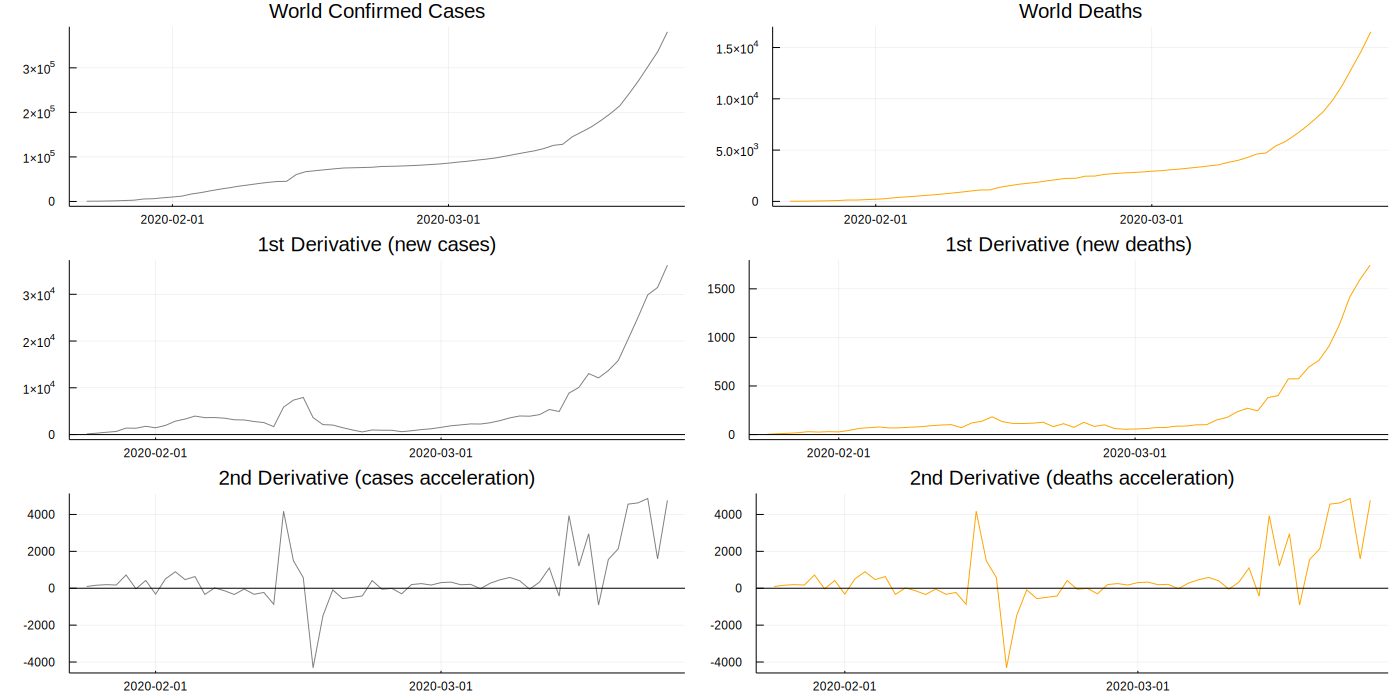

In [15]:
country_name = "World"
if country_name == "World"
    tmp = all_country_data
else
    tmp = all_country_data[all_country_data.country .== country_name, :]
end
agg = by(tmp, [:date], :confirmed => sum, :deaths => sum)
conf = plot(agg.date, agg.confirmed_sum, legend=false, title="$country_name Confirmed Cases", size=(1400, 700), color=:grey)
death = plot(agg.date, agg.deaths_sum, legend=false, title="$country_name Deaths", size=(1400, 700), color=:orange)

# derivates
agg[!, :new_cases] .= 0
agg[!, :new_cases][2:end] = agg.confirmed_sum[2:end] - agg.confirmed_sum[1:end-1]
agg[!, :new_deaths] .= 0
agg[!, :new_deaths][2:end] = agg.deaths_sum[2:end] - agg.deaths_sum[1:end-1]
agg[!, :conf_acceleration] .= 0
agg[!, :conf_acceleration][2:end] = agg.new_cases[2:end] - agg.new_cases[1:end-1]
agg[!, :death_acceleration] .= 0
agg[!, :death_acceleration][2:end] = agg.new_cases[2:end] - agg.new_cases[1:end-1]

# moving average
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
n_days = 3
ma_date = agg.date[1 + n_days-1:end]
conf_slope = moving_average(agg.new_cases, n_days)
death_slope = moving_average(agg.new_deaths, n_days)
conf_acc = moving_average(agg.conf_acceleration, n_days)
death_acc = moving_average(agg.death_acceleration, n_days)

p_conf_slope = plot(ma_date, conf_slope, legend=false, title="1st Derivative (new cases)", size=(1400, 700), color=:grey)
plot!([0], linetype=:hline, color=:black, label="")

p_death_slope = plot(ma_date, death_slope, legend=false, title="1st Derivative (new deaths)", size=(1400, 700), color=:orange)
plot!([0], linetype=:hline, color=:black, label="")

p_conf_acc = plot(ma_date, conf_acc, legend=false, title="2nd Derivative (cases acceleration)", size=(1400, 700), color=:grey)
plot!([0], linetype=:hline, color=:black, label="")

p_death_acc = plot(ma_date, death_acc, legend=false, title="2nd Derivative (deaths acceleration)", size=(1400, 700), color=:orange)
plot!([0], linetype=:hline, color=:black, label="")

plot(conf, death, p_conf_slope, p_death_slope, p_conf_acc, p_death_acc, layout=(3,2))

## Top 10 Worst Affected Countries
### Confirmed

In [16]:
top_10 = sort(current_state, order(:confirmed_maximum, rev=true))[1:10, :]

,country,confirmed_maximum,deaths_maximum,death_rate
,String,Int64,Int64,Float64
1,China,81498,3274,0.0401728
2,Italy,63927,6077,0.0950616
3,US,46145,582,0.0126124
4,Spain,35136,2311,0.065773
5,Germany,29056,123,0.0042332
6,Iran,23049,1812,0.0786151
7,France,20123,862,0.0428366
8,"Korea, South",8961,111,0.012387
9,Switzerland,8795,120,0.0136441


## Days Since 100th Case

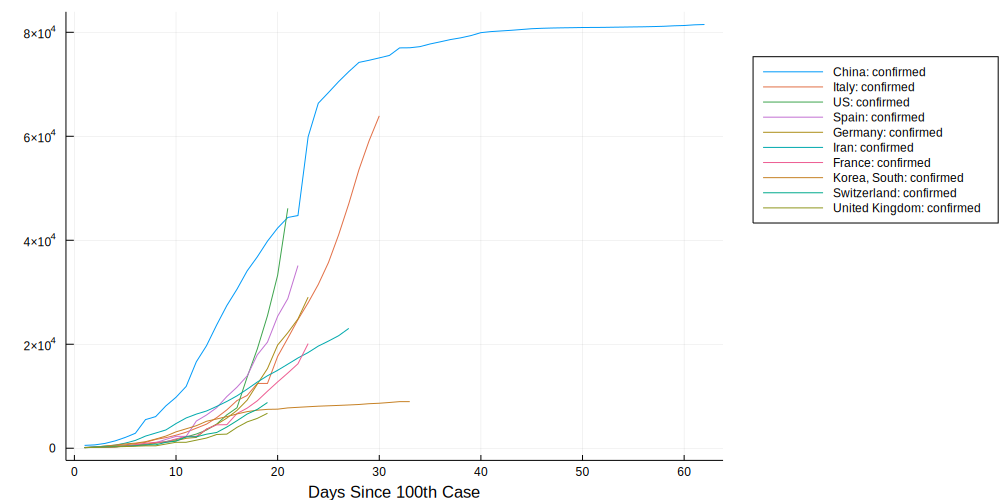

In [17]:
countries = top_10.country
fig = plot()
for country in countries
    plot_country!(country; days_since_100=true, metric=:confirmed)
end
plot!(xlabel="Days Since 100th Case")
fig

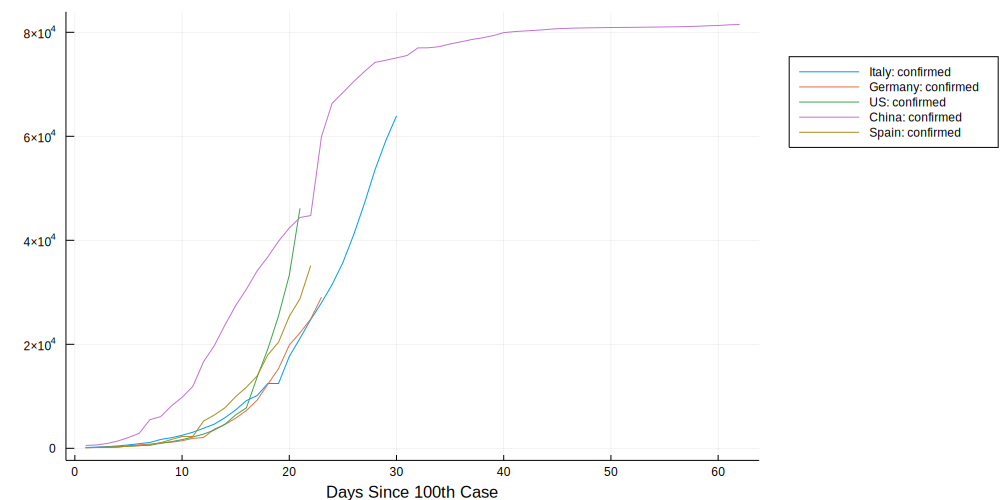

In [19]:
fig = plot()
for country in ["Italy", "Germany", "US", "China", "Spain"]
    plot_country!(country; days_since_100=true, metric=:confirmed)
end
plot!(xlabel="Days Since 100th Case")
fig

### Deaths

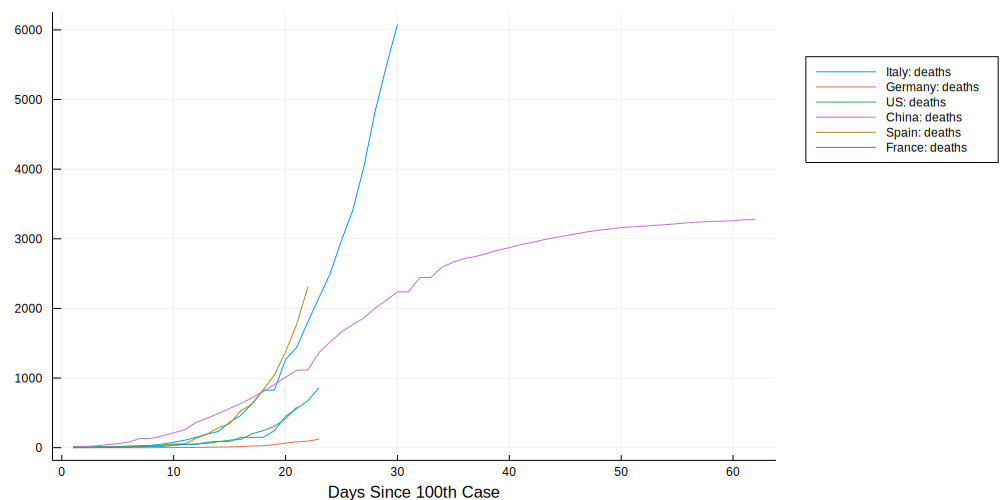

In [20]:
fig = plot()
for country in ["Italy", "Germany", "US", "China", "Spain", "France"]
    plot_country!(country; days_since_100=true, metric=:deaths)
end
plot!(xlabel="Days Since 100th Case")
fig

# Acceleration (>1000 cases now)

In [21]:
countries = unique(all_country_data.country)
acceleration = []
cases_5_ago = []
cases_now = []
for country in countries
    metric = mean(all_country_data[all_country_data.country .== country, :acceleration_cases][end-4:end])
    metric /= all_country_data[all_country_data.country .== country, :confirmed][end-4]
    if isnan(metric)
        metric = 0
    end
    push!(acceleration, metric)
    push!(cases_5_ago, all_country_data[all_country_data.country .== country, :confirmed][end-4])
    push!(cases_now, all_country_data[all_country_data.country .== country, :confirmed][end])
end
last_5 = rename!(DataFrame([countries, acceleration, cases_now, cases_5_ago]), [:country, :last_5_accel, :cases_now, :cases_5_ago])
last_5[!, :perc_increase] = last_5.cases_now ./ last_5.cases_5_ago .- 1
tmp = sort(last_5[(last_5.cases_5_ago .> 20) .& (last_5.cases_now .> 1000), :], order(:last_5_accel, rev=true))
tmp[!, :perc_increase] = string.(round.(tmp.perc_increase .* 100, digits=2)) .* "%"
tmp

,country,last_5_accel,cases_now,cases_5_ago,perc_increase
,Any,Any,Any,Any,String
1,Turkey,0.252083,1529,192,696.35%
2,US,0.168268,46145,13677,237.39%
3,Portugal,0.117197,2060,785,162.42%
4,Canada,0.11,2088,800,161.0%
5,Brazil,0.105314,1924,621,209.82%
6,Israel,0.0812408,1442,677,113.0%
7,Austria,0.0574267,4474,2013,122.26%
8,Ireland,0.05386,1125,557,101.97%
9,Switzerland,0.0487362,8795,4075,115.83%


## China, Iran, South Korea
### Confirmed Cases

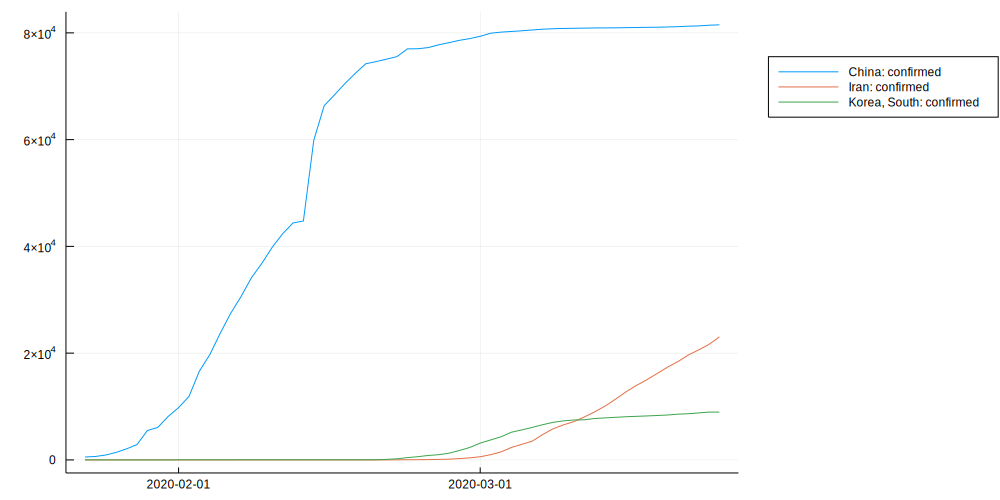

In [22]:
europe = ["China", "Iran", "Korea, South"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 1, 1))
end
fig

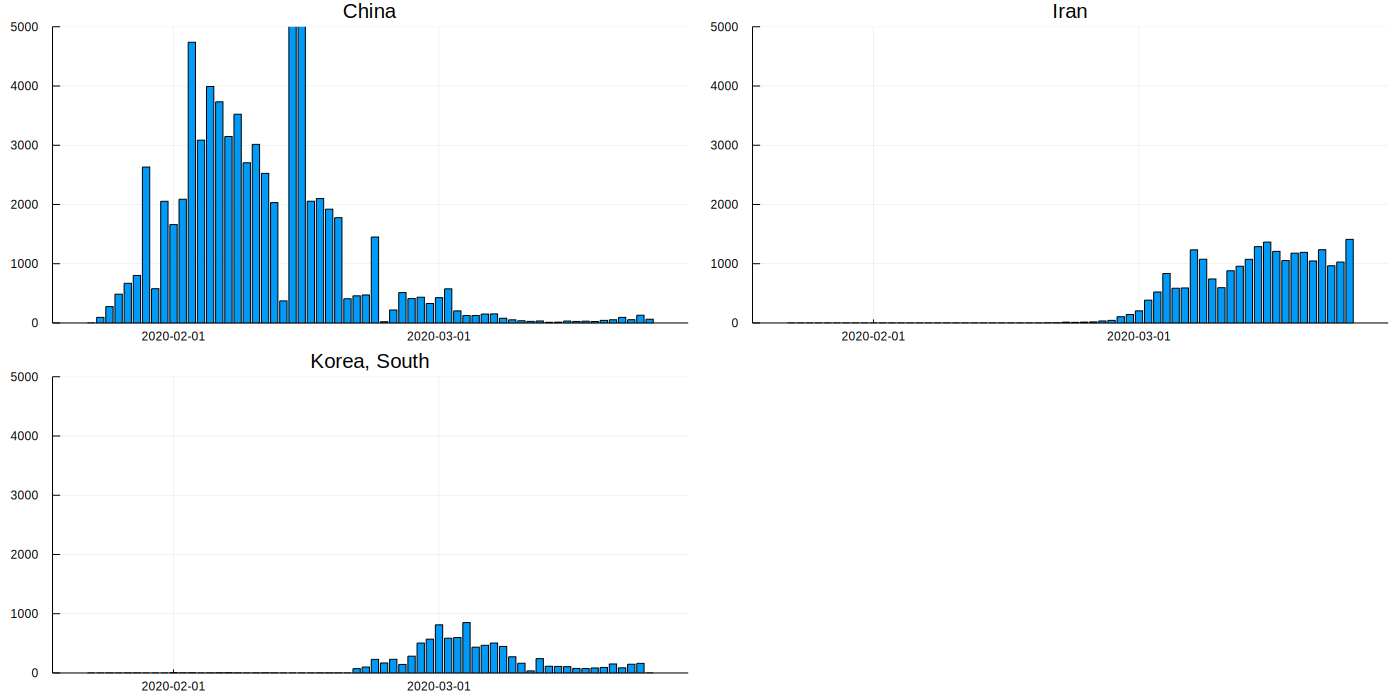

In [23]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 1, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 1, 1)), :new_cases], legend=false, title=country, ylim=(0, 5000))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., plot(legend=false,grid=false,foreground_color_subplot=:white), layout=(2, 2), size=(1400, 700))

## Europe + US
### Confirmed Cases

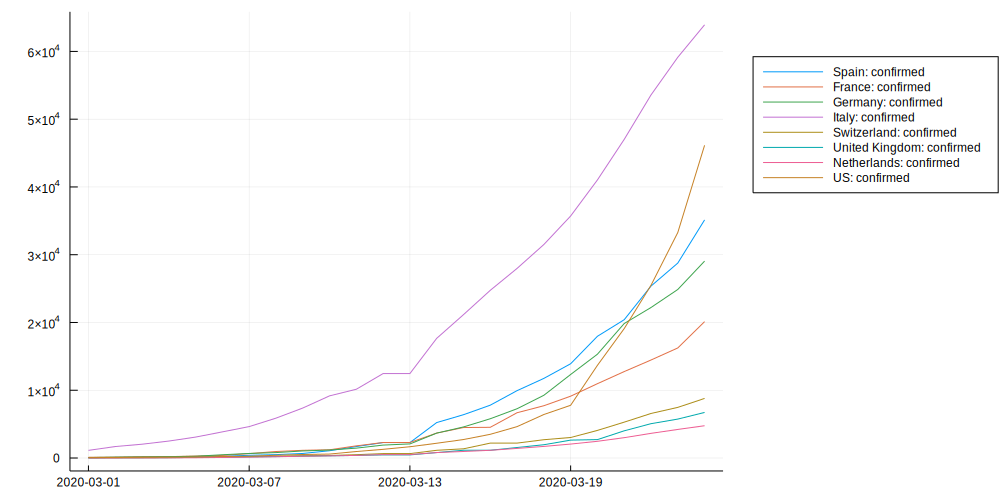

In [24]:
europe = ["Spain", "France", "Germany", "Italy", "Switzerland", "United Kingdom", "Netherlands", "US"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig

### Deaths

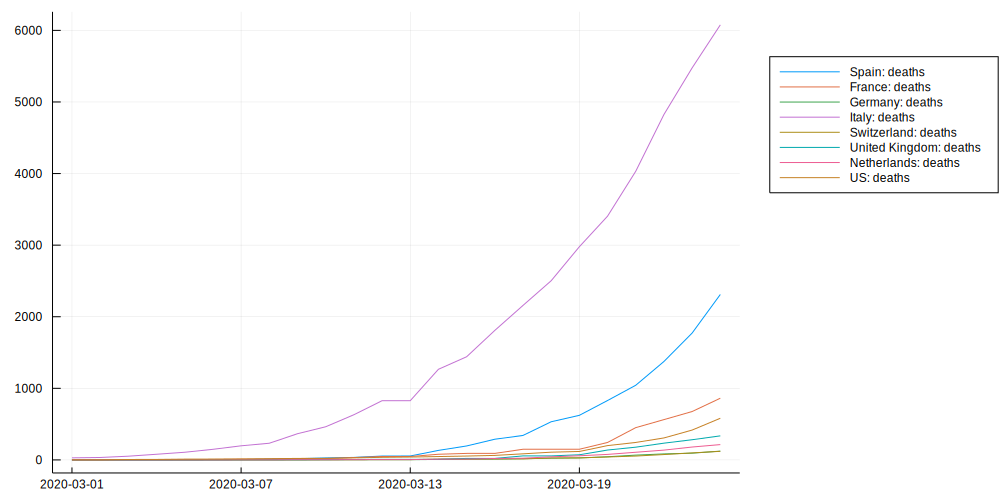

In [25]:
europe = ["Spain", "France", "Germany", "Italy", "Switzerland", "United Kingdom", "Netherlands", "US"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1), metric=:deaths)
end
fig

### New Cases per Day

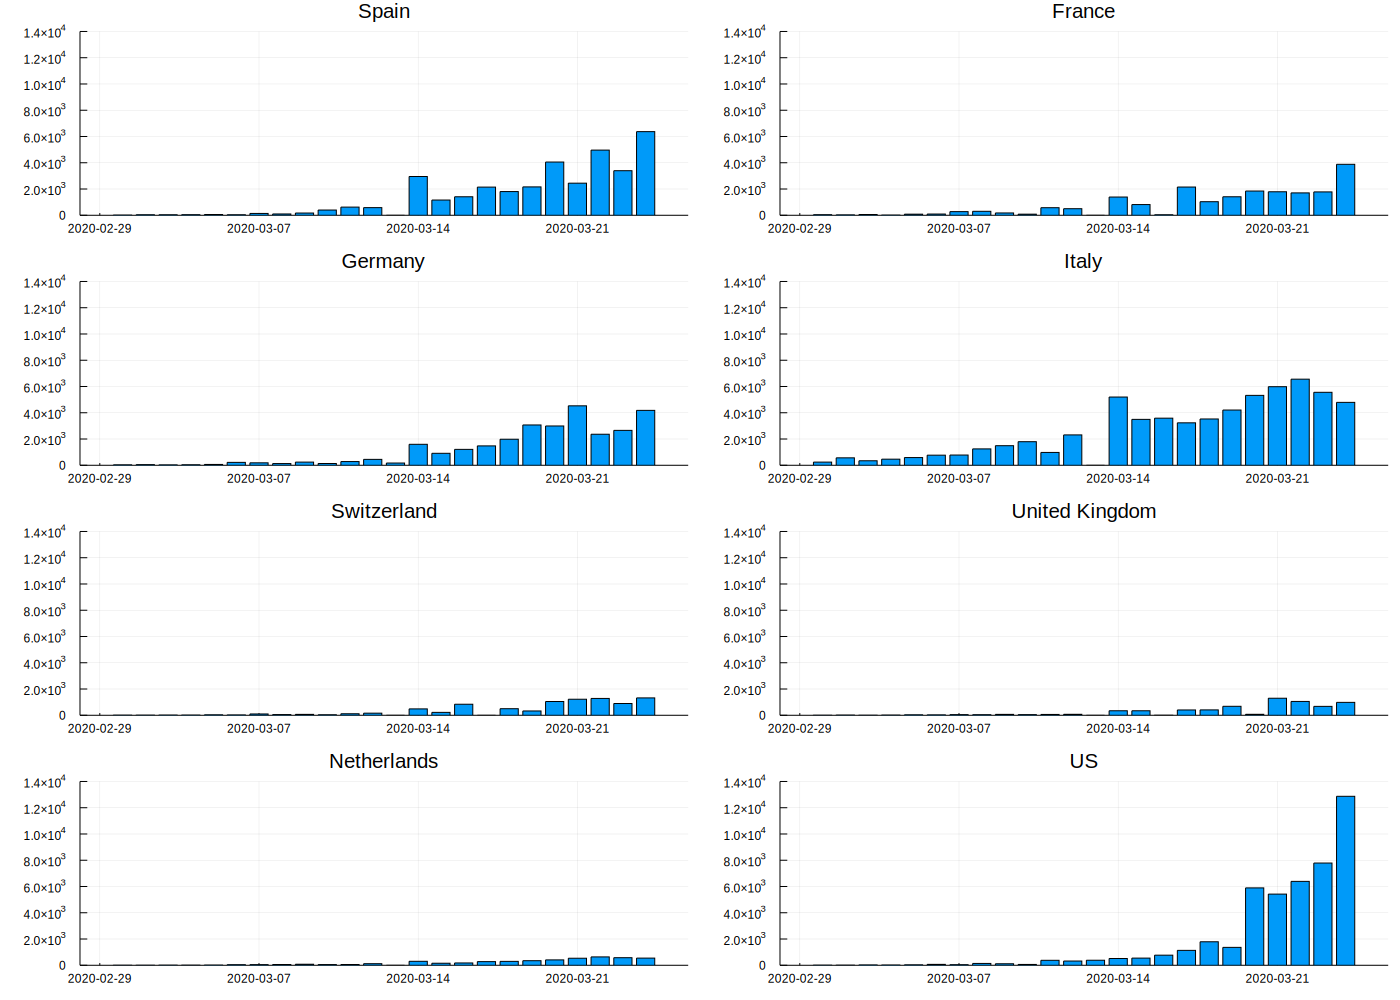

In [31]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, title=country, ylim=(0, 14000))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(4, 2), size=(1400, 1000))

### New Deaths per Day

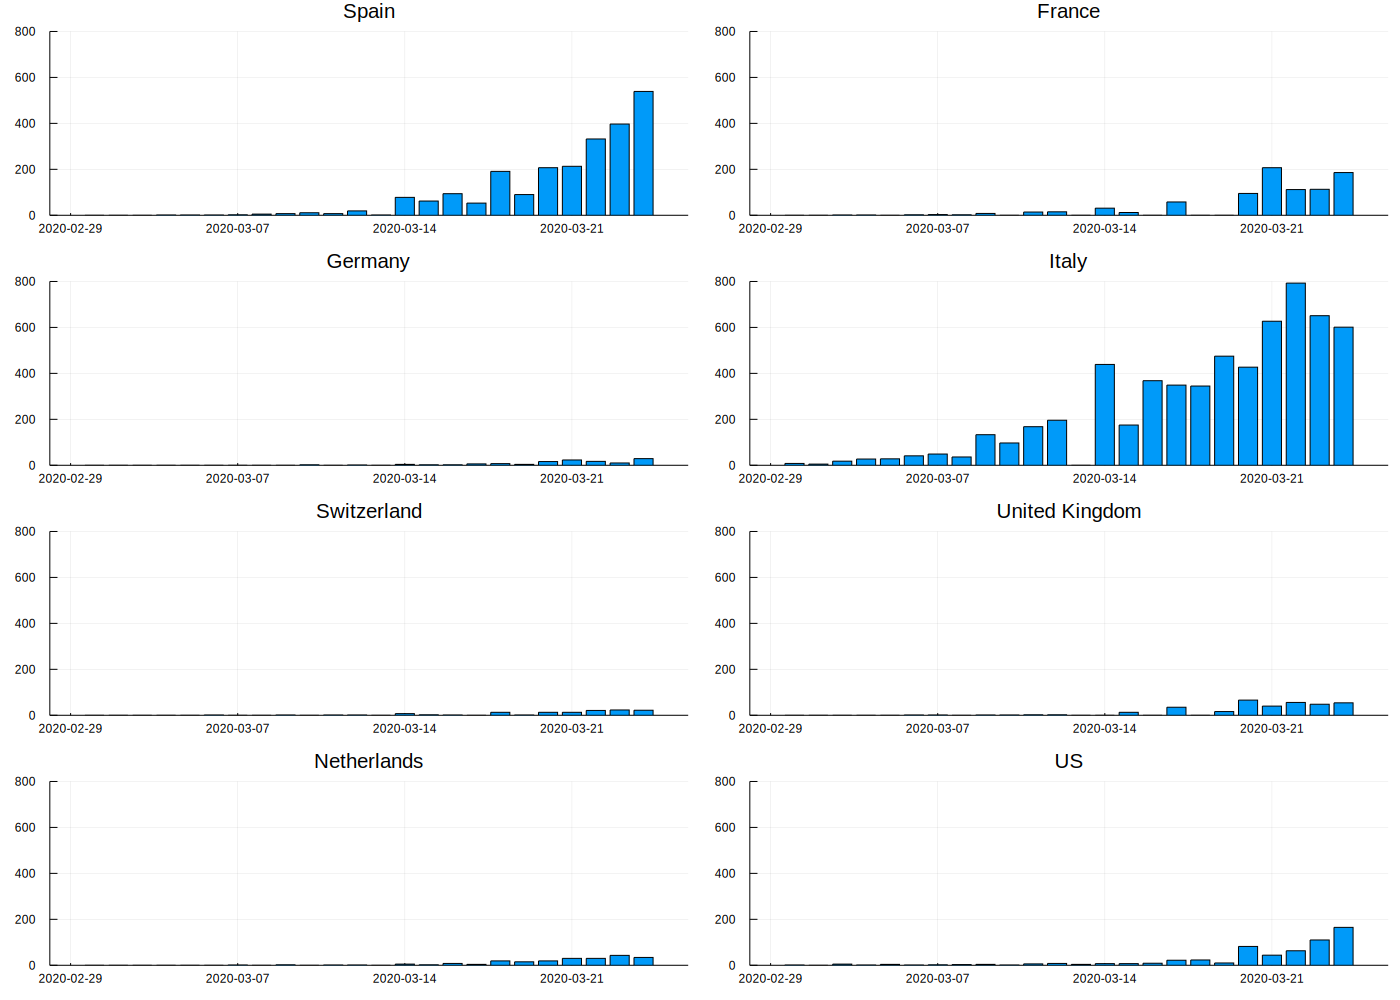

In [32]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_deaths], legend=false, title=country, ylim=(0, 800))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(4, 2), size=(1400, 1000))

## Asia (- S. Korea, China)
### Confirmed Cases

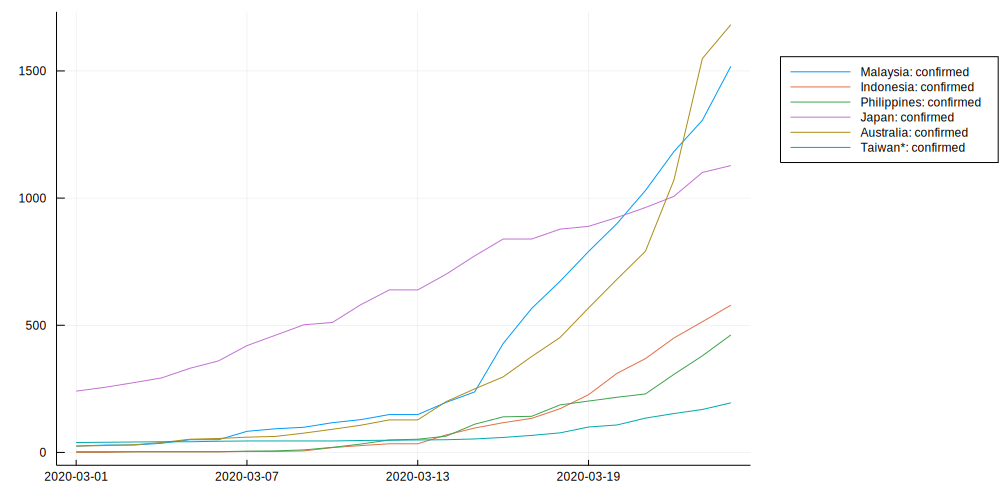

In [33]:
europe = ["Malaysia", "Indonesia", "Philippines", "Japan", "Australia", "Taiwan*"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig

### New Cases per Day

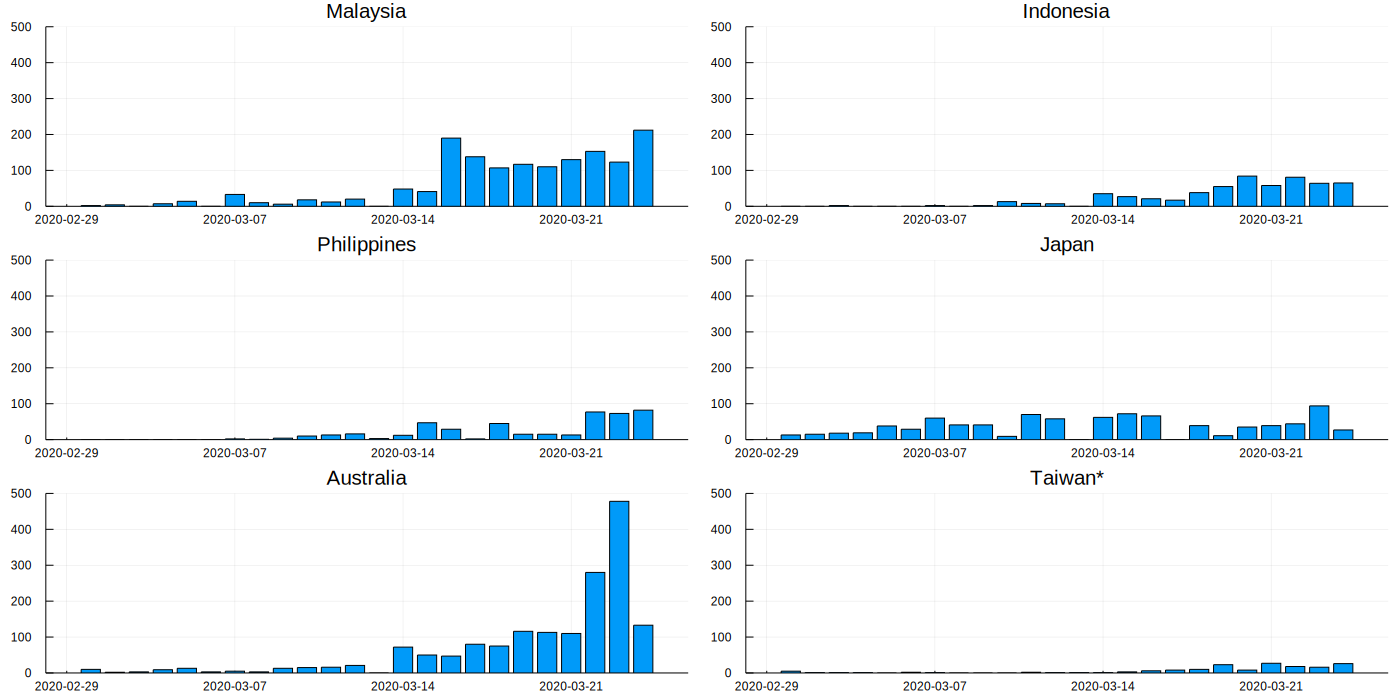

In [34]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, title=country, ylim=(0, 500))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(3, 2), size=(1400, 700))

## South America
### Confirmed Cases

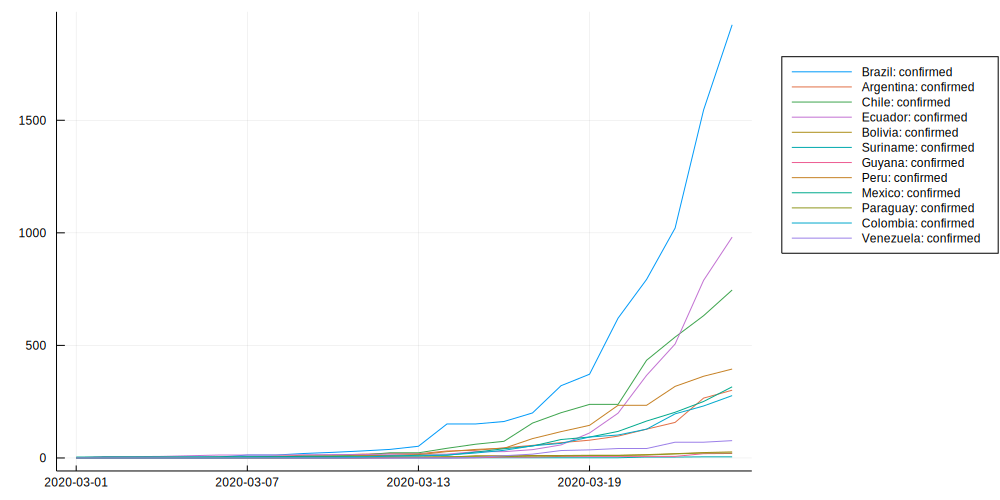

In [35]:
europe = ["Brazil", "Argentina", "Chile", "Ecuador", "Bolivia", "Suriname", "Guyana", "Peru", "Mexico", "Paraguay", "Colombia", "Venezuela"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig

### New Cases per Day

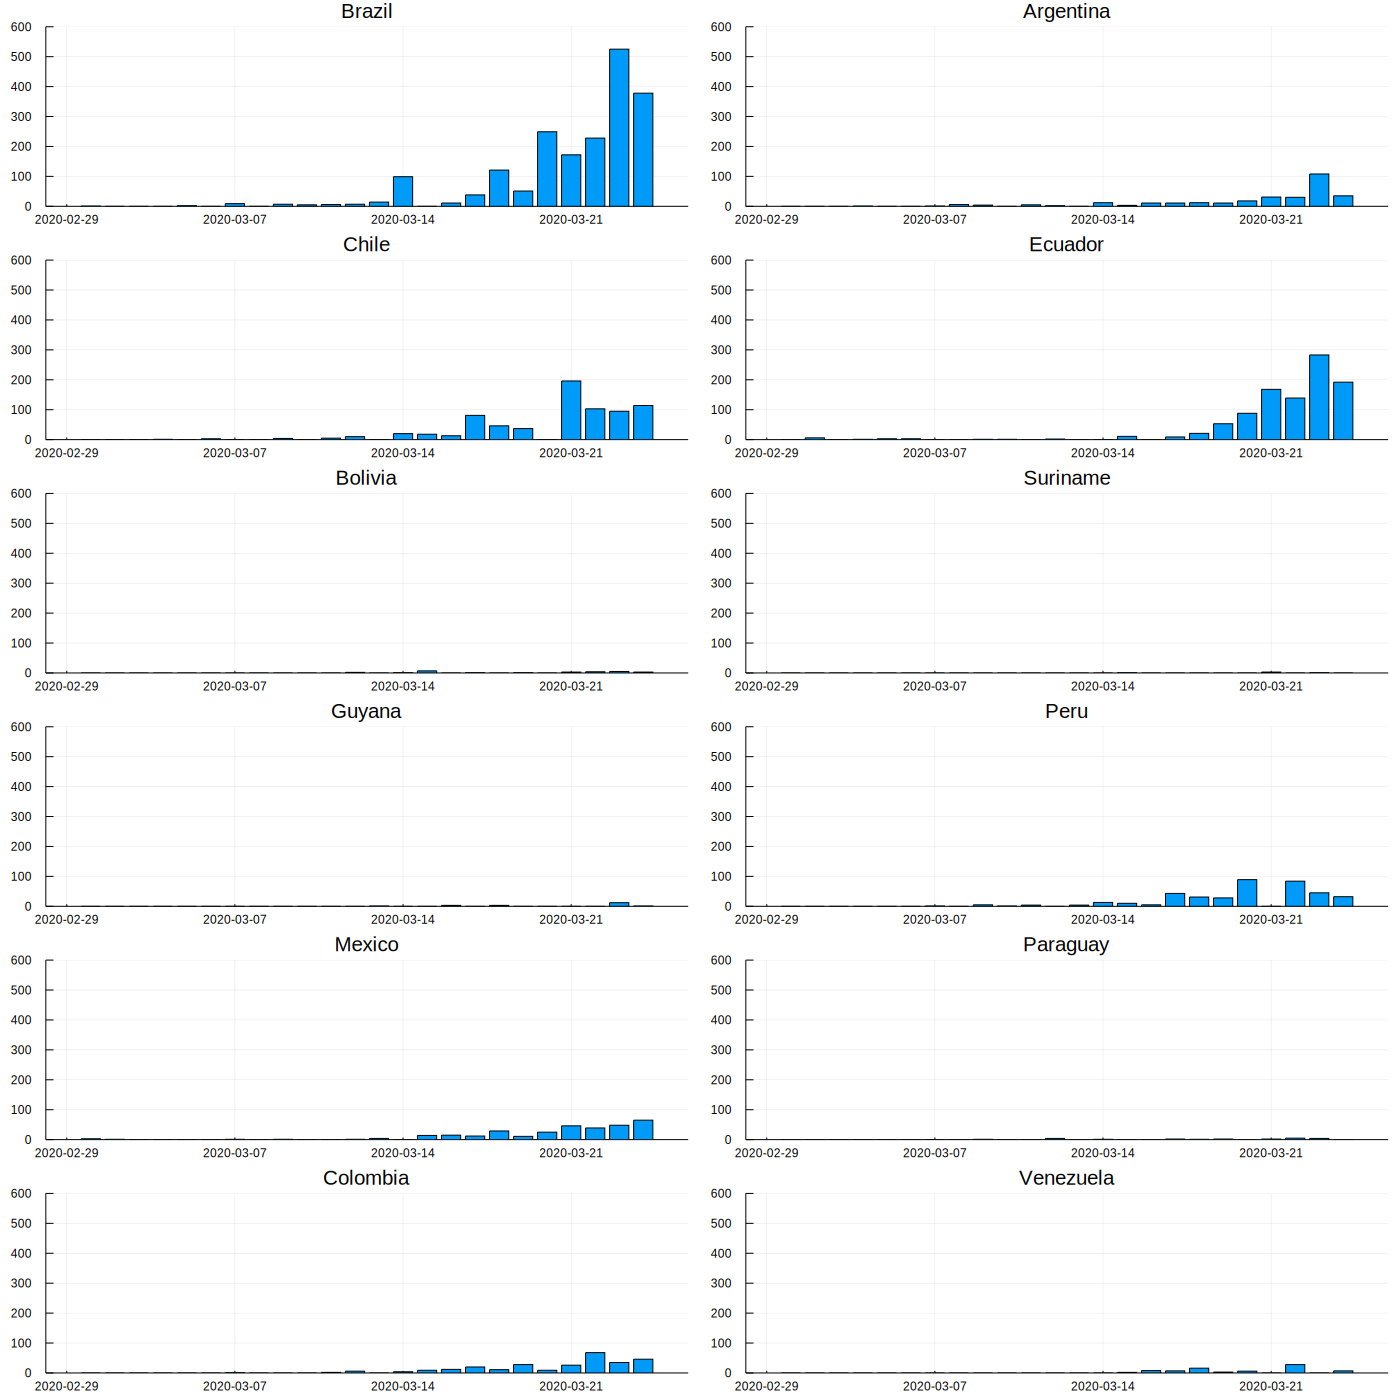

In [36]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, title=country, ylim=(0, 600))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(6, 2), size=(1400, 1400))

## Hungary
## Confirmed Cases

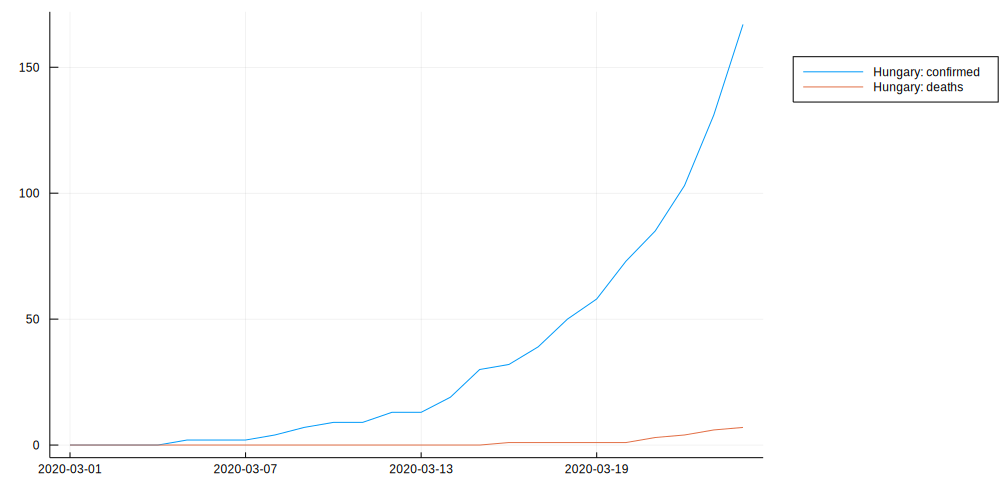

In [37]:
europe = ["Hungary"]
fig = plot()
for country in europe
    plot_country!(country; start_date=Dates.Date(2020, 3, 1))
end
fig
plot_country!(europe[1]; start_date=Dates.Date(2020, 3, 1), metric=:deaths)

### New Cases per Day

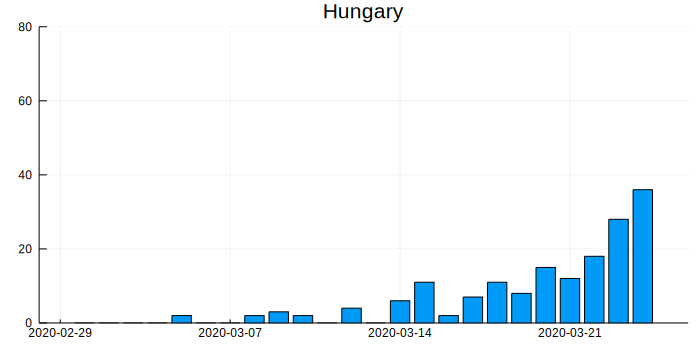

In [38]:
bar_plot(country) = bar(all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :date], all_country_data[(all_country_data.country .== country) .& (all_country_data.date .>= Dates.Date(2020, 3, 1)), :new_cases], legend=false, title=country, ylim=(0, 80))
eu_plots = []
for country in europe
    push!(eu_plots, bar_plot(country))
end
plot(eu_plots..., layout=(1, 1), size=(700, 350))